<h1>ALY6015_SpringA2020_Team#1</h1>

<p><b>Author:</b> Pragati Koladiya, Tanvi Bhagat, Munitha Priyanka</p>
<b>Purpose:</b><i> Hackathon#2</i>

<h1>Part 2 </h1>

# Time Series Analysis

- Time series analysis is the collection of data at specific intervals over a period of time, with the purpose of identifying **trends, cycles, and seasonal** variances to aid in the forecasting of a future event. 

<b>Setup environment (libraries and packages)</b>

In [0]:
#Builds 'n Installs
#!pip install scipy==1.2
!pip install -q --upgrade scipy;
!pip install -q --upgrade quandl;
!pip install -q --upgrade pandas-datareader;
!pip install -q --upgrade statsmodels;

     |████████████████████████████████| 8.7MB 2.7MB/s 


Importing packages

In [0]:
from statsmodels.tsa.stattools import adfuller
import requests
import warnings
import itertools
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import kpss
import io
import scipy
import quandl
import numpy as np
import pandas as pd
import pandas_datareader as pdr
from pandas_datareader import data, wb
import fix_yahoo_finance as yf
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot
from matplotlib.pyplot import figure
from matplotlib.pyplot import style
import matplotlib.ticker as mtick
import datetime
from datetime import date
from dateutil.parser import parse

pd.options.display.float_format = '{:.2f}'.format
plt.rcParams["figure.figsize"] = (16,12)
plt.style.use('seaborn-white')

#PARAMETERS
#drive.mount('/content/drive')
start_date = "1970-01-01"
#end_date = ""
end_date = "2020-01-01"
if end_date == "":
  end_date = datetime.datetime.now()

import matplotlib.dates as mdates

def shade_recessions():
  if start_date < "2007-01-01":
    ax.axvspan("2007-12", "2009-06", alpha=0.6, color='gray') #Great Recession ("Financial Crisis")
  if start_date < "2001-01-01":
    ax.axvspan("2001-03", "2001-11", alpha=0.6, color='gray') #Early 2000's Recession ("Dot Com Bubble")
  if start_date < "1990-01-01":
    ax.axvspan("1990-07", "1991-03", alpha=0.7, color='gray') #Early 1990's Recession ("Oil Price Shock")
  if start_date < "1981-01-01":
    ax.axvspan("1981-07", "1982-11", alpha=0.6, color='gray') #Early 1980's Recession ("Reagan")
   
def plot_grid():
  ax.grid(color='lightgray', linestyle='-', linewidth=.5)

# Load Dataset
Period related to electro


In [0]:
data_path="https://docs.google.com/spreadsheets/d/e/2PACX-1vTVOlSKndbREpJFUwSZNzwqA-fEi-9dvu6kjnUyAdROJy37sFNFDikzCMSAYFInbcGNBbYYjQPgNGAw/pub?gid=1614269700&single=true&output=csv"

fopen = requests.get(data_path).content
ds_raw=pd.read_csv(io.StringIO(fopen.decode('utf-8')),  header= 0 , parse_dates=['Period'])
ds_raw


,Period,Electro
0,1971-11-17,0.02
1,1972-04-23,0.04
2,1974-05-01,0.06
3,1979-07-28,0.29
4,1982-04-24,1.36
...,...,...
75,2011-11-26,12000.00
76,2012-05-26,24000.00
77,2012-05-30,23000.00
78,2012-09-13,21000.00


In [0]:
ds_raw.dtypes

Period     datetime64[ns]
Electro           float64
dtype: object

<i>Add period as index</i>

In [0]:
ds = ds_raw.copy()
ds = ds.set_index('Period')
ds.head()

,Electro
Period,
1971-11-17,0.02
1972-04-23,0.04
1974-05-01,0.06
1979-07-28,0.29
1982-04-24,1.36


<i>Changing the string dataset for period</i>
- <i>Q = Quarter end frequency</i>

In [0]:
#y = np.log(ds['Electro'])
#y_values = ds['Electro']
y_values = ds['Electro'].resample('Q').mean()
y_values


Period
1971-12-31       0.02
1972-03-31        nan
1972-06-30       0.04
1972-09-30        nan
1972-12-31        nan
               ...   
2011-12-31   12000.00
2012-03-31        nan
2012-06-30   23500.00
2012-09-30   21000.00
2012-12-31   12000.00
Freq: Q-DEC, Name: Electro, Length: 165, dtype: float64

- <i>Checking null values</i>

In [0]:
y_values.isna().sum()

112

- Back filling the null values

In [0]:
y_values = y_values.fillna(y_values.bfill())

In [0]:
y_values.isna().sum()

0

- <i>Graphical representaion of number of years vs values</i>

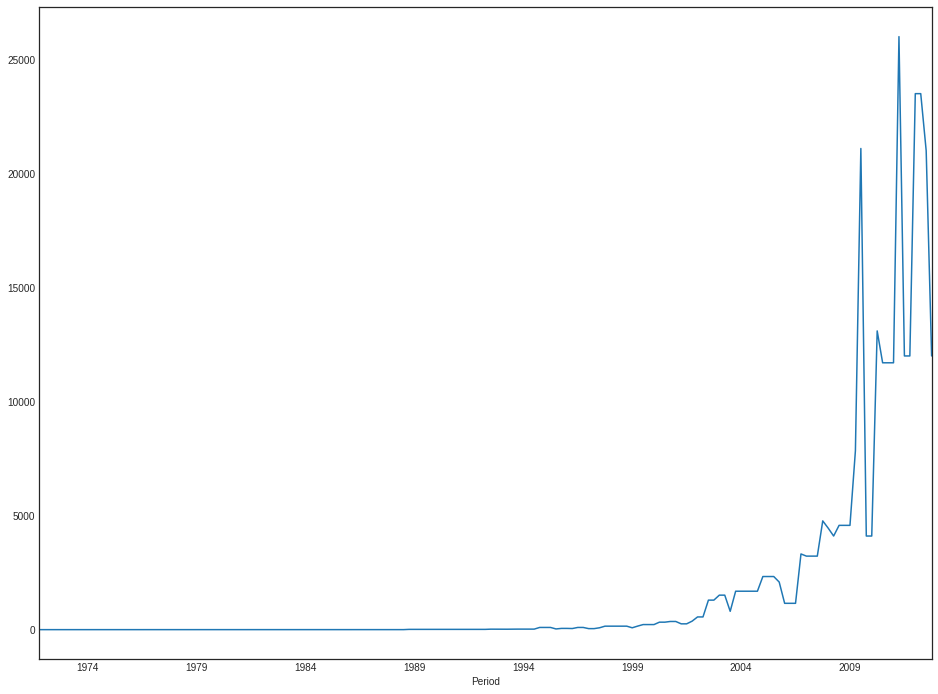

In [0]:
y_values.plot()

<h3>Converting values into log</h3>
<p><i>- The reason to use logarithmic scales in charts and graphs is to respond to skewness towards large values; i.e., cases in which one or a few points are much larger than the bulk of the data.</i></p>


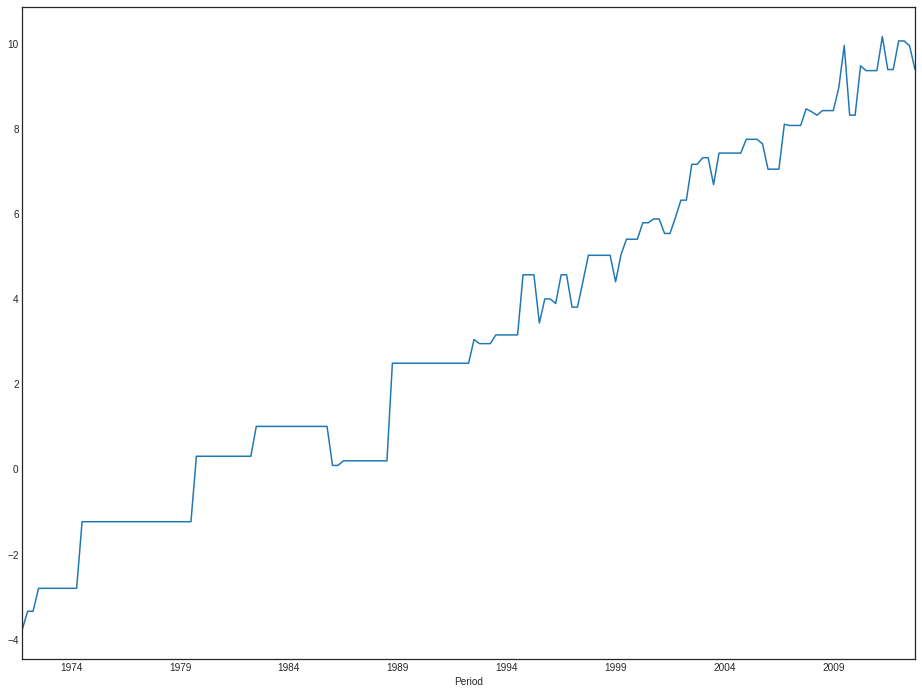

In [0]:
y = np.log(y_values)
y.plot()

<h3>Visulizing the data using additive model</h3>

- <i>Since our data has less fluctuations over the years, we have used additive model</i>
- <i>Additive model is used when the variance of the time series doesn't change over different values of the time series.</i>

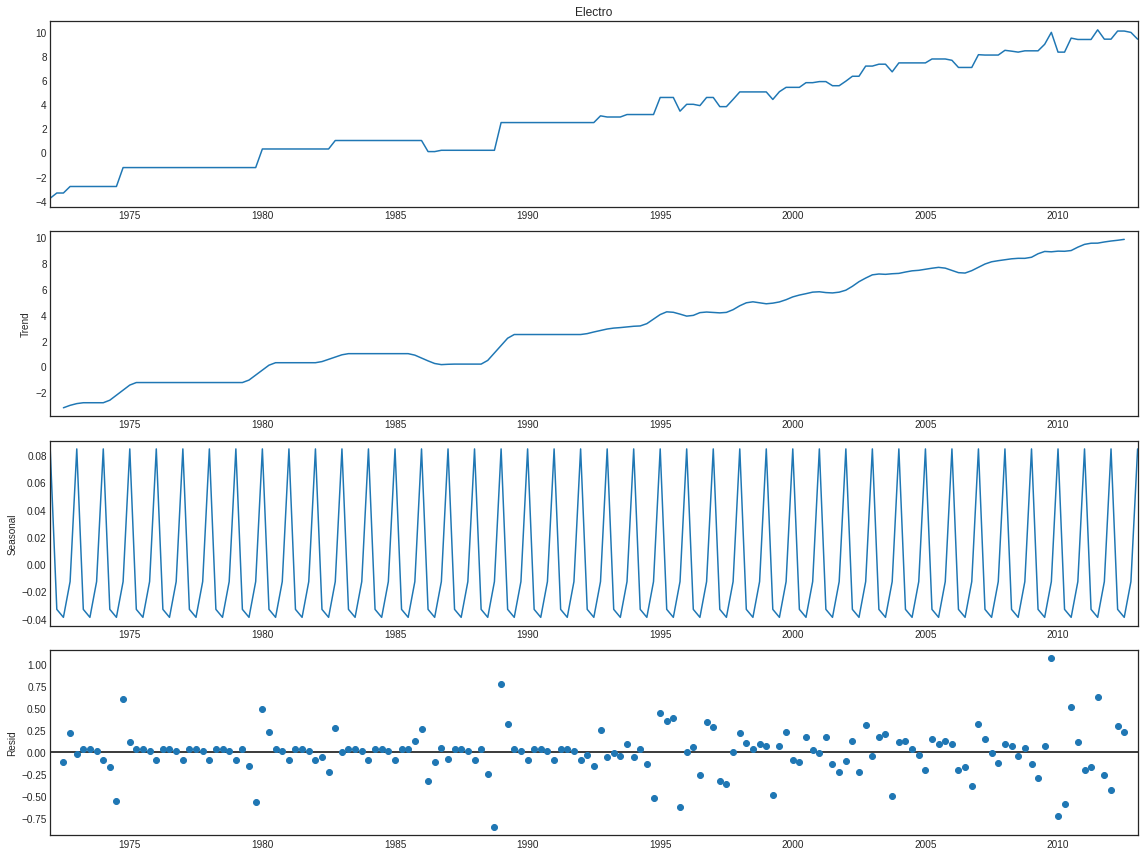

In [0]:
#Visualize the data
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

<h3>ARIMA Time Series Model:
<i>Auto</i>
<i>Regressive</i>
<i>Integrated</i>
<i>Moving</i>
<i>Average</i>
<ul>
<li>p is the auto-regressive part of the model.</li>
<li>d is the integrated part of the model.</li>
<li>q is the moving average part of the model.</li>
</ul>

In [0]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 4) for x in list(itertools.product(p, d, q))]
#seasonal_pdq = [(0,0,0, 1) ]
print(pdq)
print(seasonal_pdq)


[(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]
[(0, 0, 0, 4), (0, 0, 1, 4), (0, 1, 0, 4), (0, 1, 1, 4), (1, 0, 0, 4), (1, 0, 1, 4), (1, 1, 0, 4), (1, 1, 1, 4)]


In [0]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
model_output = pd.DataFrame(columns = ['parameters', 'results.aic'])

a = "bob"
b = "bob"
c = 1.0

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            #Only for diagnostic measures
            print('ARIMA{}x{}1 - AIC:{}'.format(param,
                                                  param_seasonal, results.aic))
            a = param
            b = param_seasonal
            c = results.aic
            model_output = model_output.append({'parameters': 'ARIMA{}x{}1'.format(a, b),
                                                'results.aic': c}, ignore_index = True)
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 4)1 - AIC:992.8783560647872
ARIMA(0, 0, 0)x(0, 0, 1, 4)1 - AIC:793.8165758081059
ARIMA(0, 0, 0)x(0, 1, 0, 4)1 - AIC:350.4279807554056
ARIMA(0, 0, 0)x(0, 1, 1, 4)1 - AIC:346.45620038143926
ARIMA(0, 0, 0)x(1, 0, 0, 4)1 - AIC:346.15373275570823
ARIMA(0, 0, 0)x(1, 0, 1, 4)1 - AIC:341.60855664017413
ARIMA(0, 0, 0)x(1, 1, 0, 4)1 - AIC:347.62075354897735
ARIMA(0, 0, 0)x(1, 1, 1, 4)1 - AIC:327.42250649423227
ARIMA(0, 0, 1)x(0, 0, 0, 4)1 - AIC:786.2511669466257
ARIMA(0, 0, 1)x(0, 0, 1, 4)1 - AIC:601.1351222211533
ARIMA(0, 0, 1)x(0, 1, 0, 4)1 - AIC:271.09613539197335
ARIMA(0, 0, 1)x(0, 1, 1, 4)1 - AIC:265.5156635988553
ARIMA(0, 0, 1)x(1, 0, 0, 4)1 - AIC:275.9562426340527
ARIMA(0, 0, 1)x(1, 0, 1, 4)1 - AIC:263.35256727019754
ARIMA(0, 0, 1)x(1, 1, 0, 4)1 - AIC:268.10417418467915
ARIMA(0, 0, 1)x(1, 1, 1, 4)1 - AIC:267.81183170313034
ARIMA(0, 1, 0)x(0, 0, 0, 4)1 - AIC:187.23173692185514
ARIMA(0, 1, 0)x(0, 0, 1, 4)1 - AIC:186.23395226177976
ARIMA(0, 1, 0)x(0, 1, 0, 4)1 - AIC:

In [0]:
model_output.describe()

,results.aic
count,64.00
mean,259.85
std,151.80
min,179.37
25%,187.16
50%,190.86
75%,267.88
max,992.88


In [0]:
model_output.tail(8)

,parameters,results.aic
56,"ARIMA(1, 1, 1)x(0, 0, 0, 4)1",186.87
57,"ARIMA(1, 1, 1)x(0, 0, 1, 4)1",186.11
58,"ARIMA(1, 1, 1)x(0, 1, 0, 4)1",253.63
59,"ARIMA(1, 1, 1)x(0, 1, 1, 4)1",179.37
60,"ARIMA(1, 1, 1)x(1, 0, 0, 4)1",186.56
61,"ARIMA(1, 1, 1)x(1, 0, 1, 4)1",184.86
62,"ARIMA(1, 1, 1)x(1, 1, 0, 4)1",223.85
63,"ARIMA(1, 1, 1)x(1, 1, 1, 4)1",183.98


In [0]:
#Fit the model with the lowest AIC above

mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 4),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6888      0.096      7.188      0.000       0.501       0.877
ma.L1         -1.0697      0.065    -16.502      0.000      -1.197      -0.943
ma.S.L4       -0.9438      0.073    -12.957      0.000      -1.087      -0.801
sigma2         0.1470      0.021      6.847      0.000       0.105       0.189


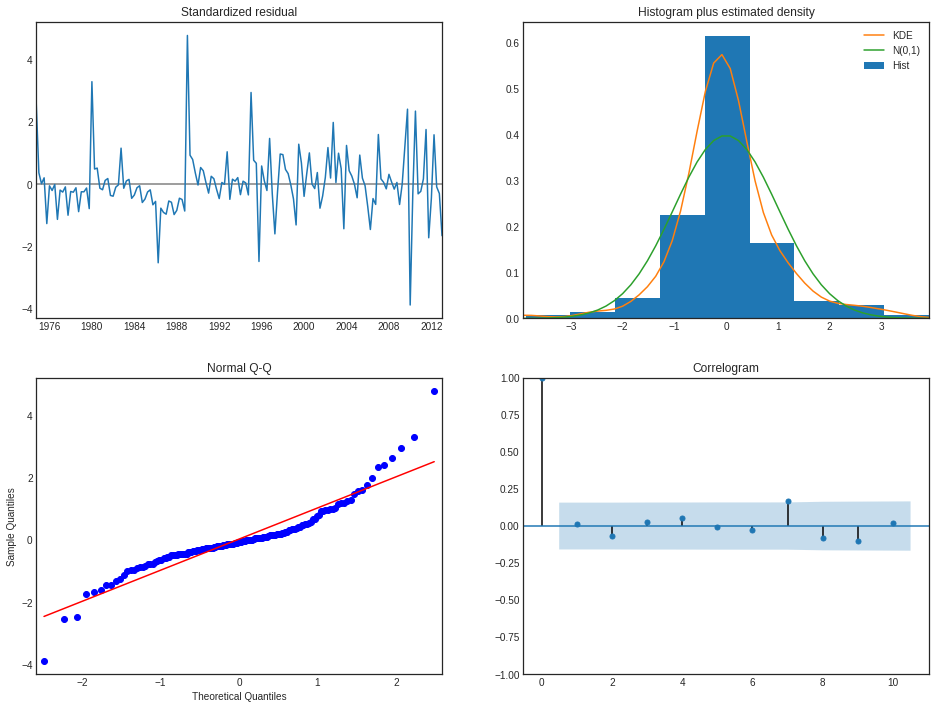

In [0]:
#Top left: Gaussian Noise
#Top right: KDE closely follows a normal distribution with a mean of 0 and an SD of 1-----N(0,1)
#Bottom left: Normal-looking Q-Q plot (i.e., data points follow the red line)
#Bottom right:
results.plot_diagnostics()
plt.show()


- <i>Validation - Not dynamic</i>

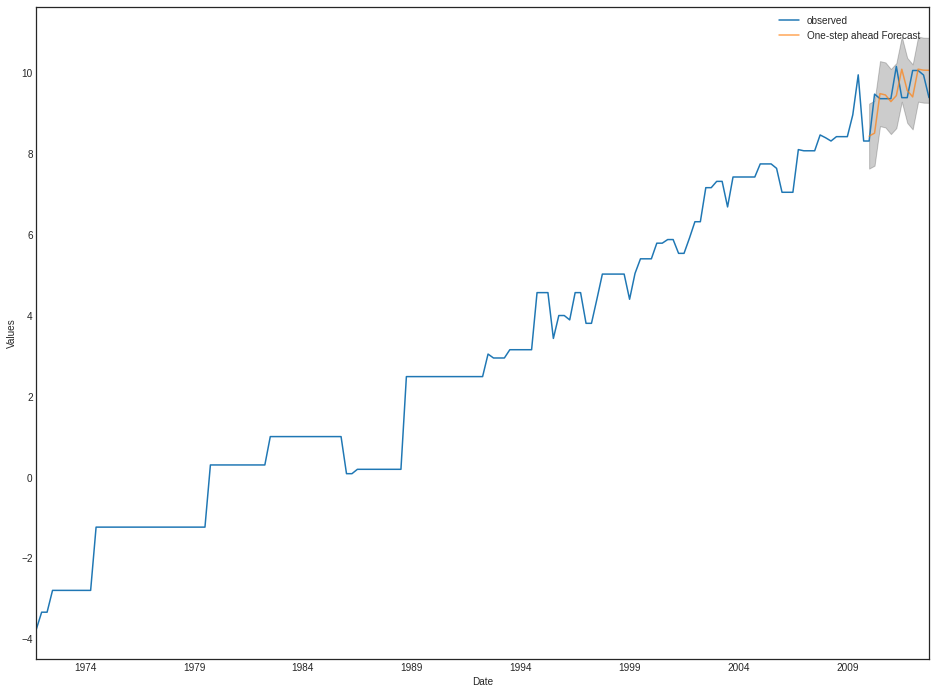

In [0]:
#Validation - not dynamic 
pred = results.get_prediction(start=pd.to_datetime('2010-03-31'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['1971':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Values')
plt.legend()

- <i>Performance Criteria to compute MSE</i>

In [0]:
#Performance Criteria
y_forecasted = pred.predicted_mean
y_truth = y['2010-03-31':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.24


**1. Predict the values for the next 8 time periods (with confidence intervals)**

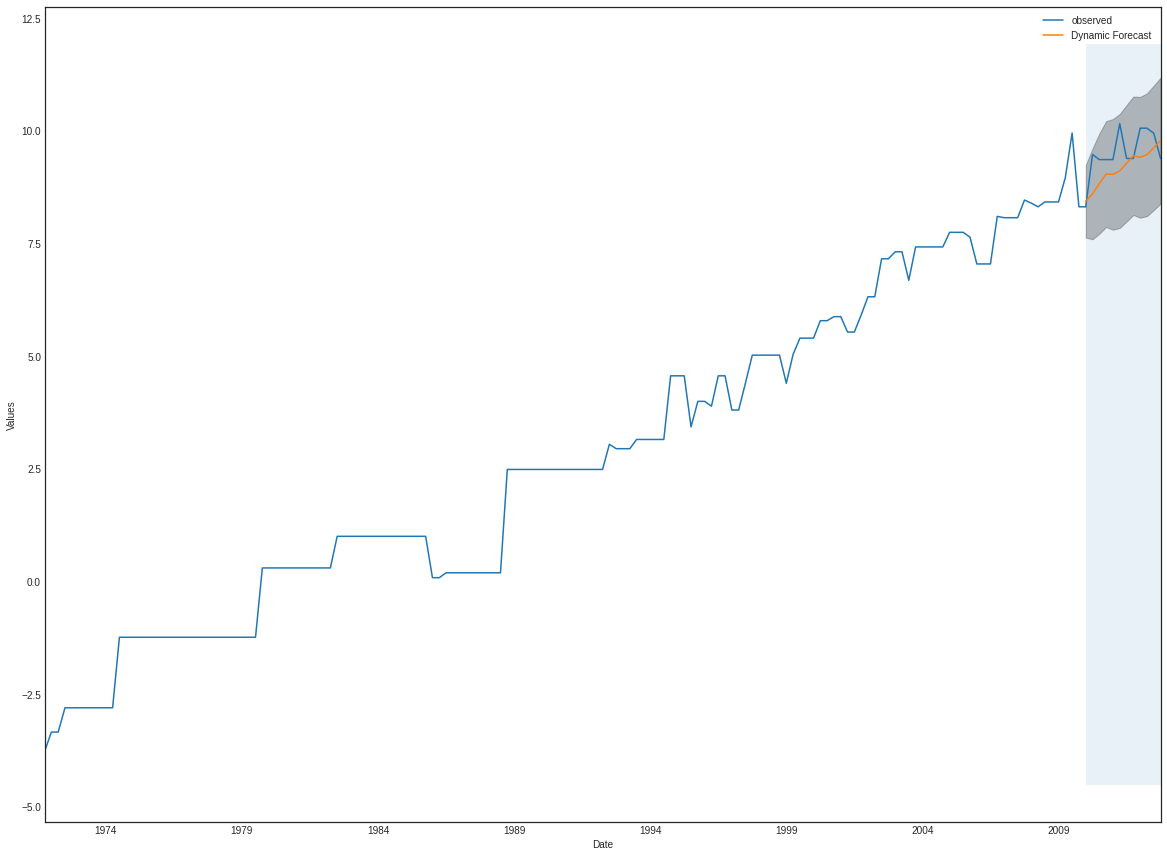

In [0]:
#Validation using dynamic forecast
pred_dynamic = results.get_prediction(start=pd.to_datetime('2010-03-31'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

ax = y['1971':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2010-03-31'), y.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Values')

plt.legend()

In [0]:
y_forecasted = pred_dynamic.predicted_mean
y_truth = y['2010-03-31':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.28


- **Preparing for a forecast**

In [0]:
#Prepare for a forecast

# Get forecast 8 steps ahead in future
pred_uc = results.get_forecast(steps=28)
pred_uc_values = np.exp(pred_uc.predicted_mean)


# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()
pred_ci_values = np.exp(pred_ci)

print('############ \n confidence interval log values')
print(pred_ci)

# converting back to values
pred_ci_values =  np.exp(pred_ci)
print('############ \n   confidence interval values')
print(pred_ci_values)

############ 
 confidence interval log values
            lower Electro  upper Electro
2013-03-31           8.73          10.34
2013-06-30           8.77          10.79
2013-09-30           8.81          11.03
2013-12-31           8.89          11.24
2014-03-31           8.87          11.33
2014-06-30           9.00          11.53
2014-09-30           9.06          11.65
2014-12-31           9.15          11.78
2015-03-31           9.14          11.81
2015-06-30           9.26          11.99
2015-09-30           9.32          12.08
2015-12-31           9.41          12.20
2016-03-31           9.39          12.22
2016-06-30           9.52          12.39
2016-09-30           9.57          12.48
2016-12-31           9.65          12.60
2017-03-31           9.64          12.62
2017-06-30           9.76          12.79
2017-09-30           9.82          12.88
2017-12-31           9.90          12.99
2018-03-31           9.88          13.02
2018-06-30          10.01          13.18
2018-09-30 

**2. Make 3 observations about the data**
- <i>2013-03-31    <b> Lower Bound:</b>   6203.57      <b> Upper Bound:</b> 31000.12  <b>Mean:</b> 13867.64</i>

- <i>2018-03-31    <b> Lower Bound:</b>  19526.14      <b> Upper Bound:</b>449938.63  <b>Mean:</b> 93731.35</i>

- <i>2019-12-31    <b> Lower Bound:</b>  32279.29      <b> Upper Bound:</b> 971579.06  <b>Mean:</b> 177092.86</i>


In [0]:
print('############ \n mean  log values')
print(pred_uc.predicted_mean)

print('############ \n   mean values')
print(pred_uc_values)

############ 
 mean  log values
2013-03-31    9.54
2013-06-30    9.78
2013-09-30    9.92
2013-12-31   10.07
2014-03-31   10.10
2014-06-30   10.27
2014-09-30   10.36
2014-12-31   10.47
2015-03-31   10.47
2015-06-30   10.63
2015-09-30   10.70
2015-12-31   10.80
2016-03-31   10.81
2016-06-30   10.95
2016-09-30   11.03
2016-12-31   11.13
2017-03-31   11.13
2017-06-30   11.27
2017-09-30   11.35
2017-12-31   11.45
2018-03-31   11.45
2018-06-30   11.59
2018-09-30   11.67
2018-12-31   11.77
2019-03-31   11.77
2019-06-30   11.91
2019-09-30   11.99
2019-12-31   12.08
Freq: Q-DEC, dtype: float64
############ 
   mean values
2013-03-31    13867.64
2013-06-30    17690.95
2013-09-30    20340.00
2013-12-31    23530.61
2014-03-31    24355.23
2014-06-30    28798.70
2014-09-30    31424.18
2014-12-31    35067.46
2015-03-31    35407.01
2015-06-30    41157.45
2015-09-30    44384.13
2015-12-31    49130.03
2016-03-31    49329.48
2016-06-30    57120.92
2016-09-30    61436.10
2016-12-31    67881.34
2017-03-31 

- <i>Graphical representaion for predicted mean plot </i>

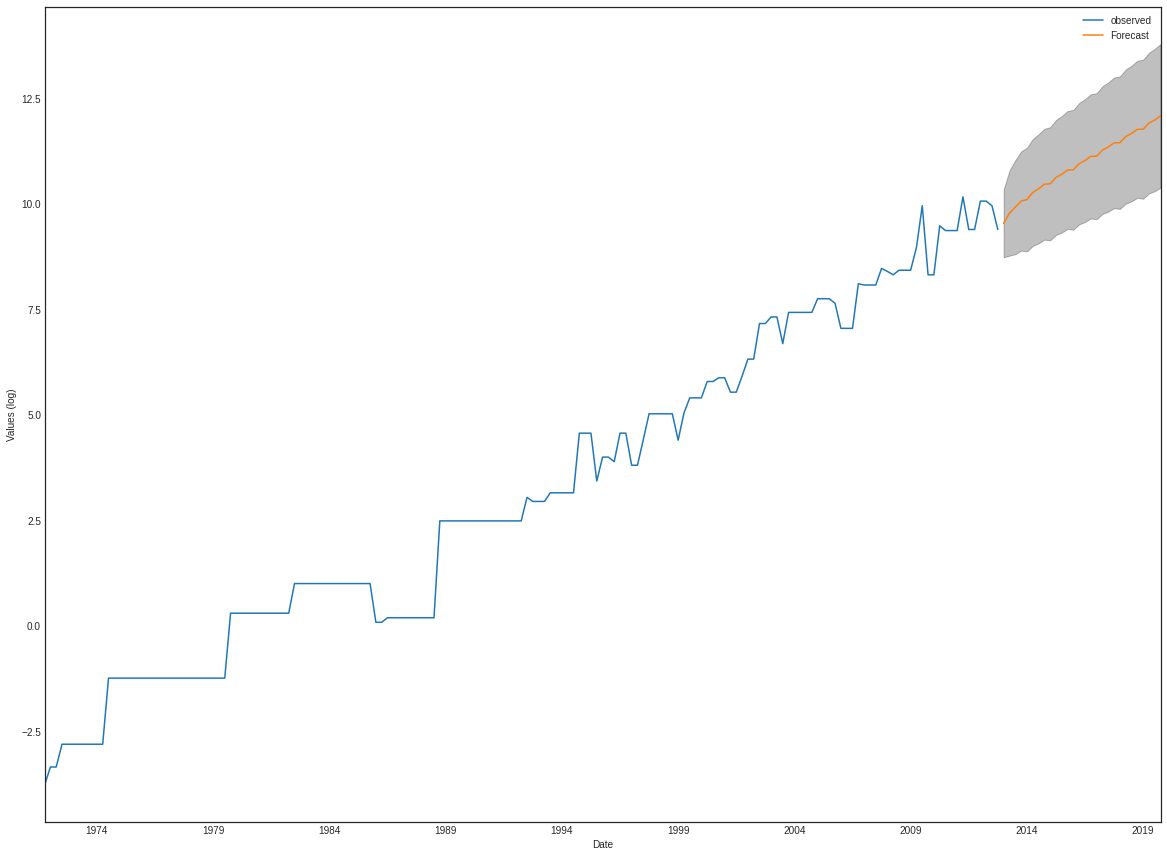

In [0]:
ax = y.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Values (log)')

plt.legend()

- <i>Graphical representaion of predicted values plot</i>

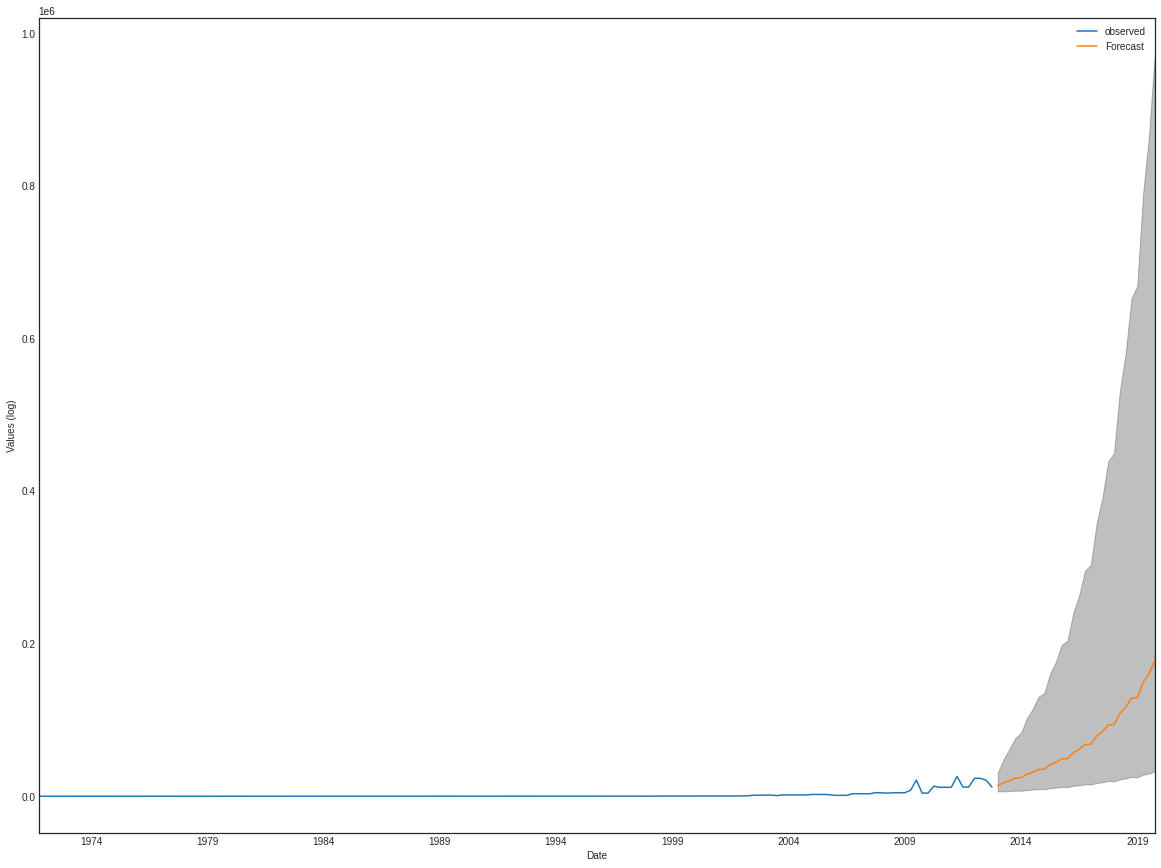

In [0]:
ax = y_values.plot(label='observed', figsize=(20, 15))
pred_uc_values.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci_values.index,
                pred_ci_values.iloc[:, 0],
                pred_ci_values.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Values (log)')

plt.legend()

<h2><b>Conclusion:</b></h2>

- <p>As the mean square error of our forecasts is 0.24, we believe that above predictions are correct.</p>